<a href="https://colab.research.google.com/github/ko-i/study/blob/main/tensorflow2/code46.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [3]:
inputs = keras.Input(shape=(784,), name='digits')
x1 = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x2 = layers.Dense(64, activation='relu', name='dense_2')(x1)
outputs = layers.Dense(10, name='predictions')(x2)
model = keras.Model(inputs, outputs)

In [4]:
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (-1, 784))
x_test = np.reshape(x_test, (-1, 784))

x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
epochs = 2

for epoch in range(epochs):
    print('\nStart of epoch %d' % (epoch,))

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        if step % 200 == 0:
            print('Training loss (for one batch) at step %d: %.4f' % (step, float(loss_value)))
            print('Seen so far: %s samples' % ((step + 1) * batch_size))


Start of epoch 0
Training loss (for one batch) at step 0: 72.6919
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.1963
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.2432
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.7934
Seen so far: 38464 samples

Start of epoch 1
Training loss (for one batch) at step 0: 0.6322
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.7234
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.5286
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.3264
Seen so far: 38464 samples


In [6]:
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, name='predictions')(x)
model = keras.Model(inputs, outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-3)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

In [7]:
import time

epochs = 2
for epoch in range(epochs):
    print('\nStart epoch: ', epoch)
    start_time = time.time()

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        train_acc_metric.update_state(y_batch_train, logits)

        if step % 200 == 0:
            print('Training loss (for one batch) at step %d is %.4f' % (step, float(loss_value)))
            print('Seen so far: %d samples' % ((step+1) * batch_size))
        
    train_acc = train_acc_metric.result()
    print('Training acc over epoch: %.4f' % (float(train_acc)))
    train_acc_metric.reset_states()

    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val, training=False)
        val_acc_metric.update_state(y_batch_val, val_logits)
        
    val_acc = val_acc_metric.result()
    print('Validation acc: %.4f' % (float(val_acc)))
    val_acc_metric.reset_states()
    print('Time taken: %.2fs' % (time.time() - start_time))


Start epoch:  0
Training loss (for one batch) at step 0 is 112.0508
Seen so far: 64 samples
Training loss (for one batch) at step 200 is 1.3390
Seen so far: 12864 samples
Training loss (for one batch) at step 400 is 1.0645
Seen so far: 25664 samples
Training loss (for one batch) at step 600 is 0.9612
Seen so far: 38464 samples
Training acc over epoch: 0.7274
Validation acc: 0.8428
Time taken: 5.79s

Start epoch:  1
Training loss (for one batch) at step 0 is 1.0382
Seen so far: 64 samples
Training loss (for one batch) at step 200 is 0.4920
Seen so far: 12864 samples
Training loss (for one batch) at step 400 is 0.7480
Seen so far: 25664 samples
Training loss (for one batch) at step 600 is 0.5076
Seen so far: 38464 samples
Training acc over epoch: 0.8482
Validation acc: 0.8560
Time taken: 5.76s


In [8]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    train_acc_metric.update_state(y, logits)
    return loss_value

In [9]:
@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)

In [10]:
import time

epochs = 2
for epoch in range(epochs):
    print('\nStart epoch: %d' % (epoch))
    start_time = time.time()

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_batch_train, y_batch_train)

        if step % 200 == 0:
            print('Training loss (for one batch) at step %d: %.4f' % (step, float(loss_value)))
            print('Seen so far: %d samples' % ((step + 1) * batch_size))
    
    train_acc = train_acc_metric.result()
    print('Training acc over epoch: %.4f' % (float(train_acc)))
    train_acc_metric.reset_states()

    for x_batch_val, y_batch_val in val_dataset:
        test_step(x_batch_val, y_batch_val)
    
    val_acc = val_acc_metric.result()
    print('Validation acc: %.4f' % (float(val_acc)))
    val_acc_metric.reset_states()

    print('Time taken: %.2fs' % (time.time() - start_time))


Start epoch: 0
Training loss (for one batch) at step 0: 0.6392
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.5159
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.4131
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.7852
Seen so far: 38464 samples
Training acc over epoch: 0.8768
Validation acc: 0.8901
Time taken: 1.57s

Start epoch: 1
Training loss (for one batch) at step 0: 0.8146
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.4378
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.2408
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.4092
Seen so far: 38464 samples
Training acc over epoch: 0.8936
Validation acc: 0.9016
Time taken: 1.14s


In [11]:
class ActivityRegularizationLayer(keras.layers.Layer):
    def call(self, inputs):
        self.add_loss(1e-2 * tf.reduce_sum(inputs))
        return inputs

In [12]:
inputs = keras.Input(shape=(784, ), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = ActivityRegularizationLayer()(x)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, name='predictions')(x)
model = keras.Model(inputs, outputs)

In [13]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
        loss_value += sum(model.losses)
    
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)

    return loss_value

In [14]:
discriminator = keras.Sequential([
    layers.InputLayer(input_shape=(28, 28, 1)),
    layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.GlobalMaxPooling2D(),
    layers.Dense(1)
], name='discriminator')

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 74,625
Trainable params: 74,625
Non-trainable params: 0
_________________________________________________

In [15]:
latent_dim = 128

generator = keras.Sequential([
    layers.InputLayer(input_shape=(latent_dim,)),
    layers.Dense(7*7*128),
    layers.LeakyReLU(alpha=0.2),
    layers.Reshape((7, 7, 128)),
    layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(1, (7, 7), padding='same', activation='sigmoid')
], name='generator')

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              809088    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)       0 

In [16]:
d_optimizer = keras.optimizers.Adam(learning_rate=0.0003)
g_optimizer = keras.optimizers.Adam(learning_rate=0.0004)

loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function
def train_step(real_images):
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    generated_images = generator(random_latent_vectors)

    combined_images = tf.concat([generated_images, real_images], axis=0)

    labels = tf.concat([tf.ones(shape=(batch_size, 1)), tf.zeros(shape=(real_images.shape[0], 1))], axis=0)
    labels += 0.05 * tf.random.uniform(labels.shape)

    with tf.GradientTape() as tape:
        predictions = discriminator(combined_images)
        d_loss = loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, discriminator.trainable_weights)
    d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    misleading_labels = tf.zeros((batch_size, 1))

    with tf.GradientTape() as tape:
        predictions = discriminator(generator(random_latent_vectors))
        g_loss = loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, generator.trainable_weights)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))

    return d_loss, g_loss, generated_images

In [17]:
batch_size = 64
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype('float32') / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

In [22]:
import os

epochs = 20
save_dir = './'

my_images = []

for epoch in range(epochs):
    print('\nStart epoch: {}'.format(epoch))

    for step, real_images in enumerate(dataset):
        d_loss, g_loss, generated_images = train_step(real_images)

        if step % 200 == 0:
            print("discriminator loss at step %d: %.2f" % (step, d_loss))
            print("adversarial loss at step %d: %.2f" % (step, g_loss))

            img = tf.keras.preprocessing.image.array_to_img(generated_images[0] * 255.0, scale=False)
            img.save(os.path.join(save_dir, 'generated_img_' + str(epoch) + '_' + str(step) + '.png'))
    
    my_images.append(img)  


Start epoch: 0
discriminator loss at step 0: 0.64
adversarial loss at step 0: 1.04
discriminator loss at step 200: 0.53
adversarial loss at step 200: 0.86
discriminator loss at step 400: 0.67
adversarial loss at step 400: 1.05
discriminator loss at step 600: 0.66
adversarial loss at step 600: 0.89
discriminator loss at step 800: 0.55
adversarial loss at step 800: 1.00
discriminator loss at step 1000: 0.67
adversarial loss at step 1000: 0.75

Start epoch: 1
discriminator loss at step 0: 0.73
adversarial loss at step 0: 1.03
discriminator loss at step 200: 0.69
adversarial loss at step 200: 0.83
discriminator loss at step 400: 0.66
adversarial loss at step 400: 0.77
discriminator loss at step 600: 0.64
adversarial loss at step 600: 0.87
discriminator loss at step 800: 0.42
adversarial loss at step 800: 1.34
discriminator loss at step 1000: 0.52
adversarial loss at step 1000: 1.20

Start epoch: 2
discriminator loss at step 0: 0.55
adversarial loss at step 0: 1.26
discriminator loss at st

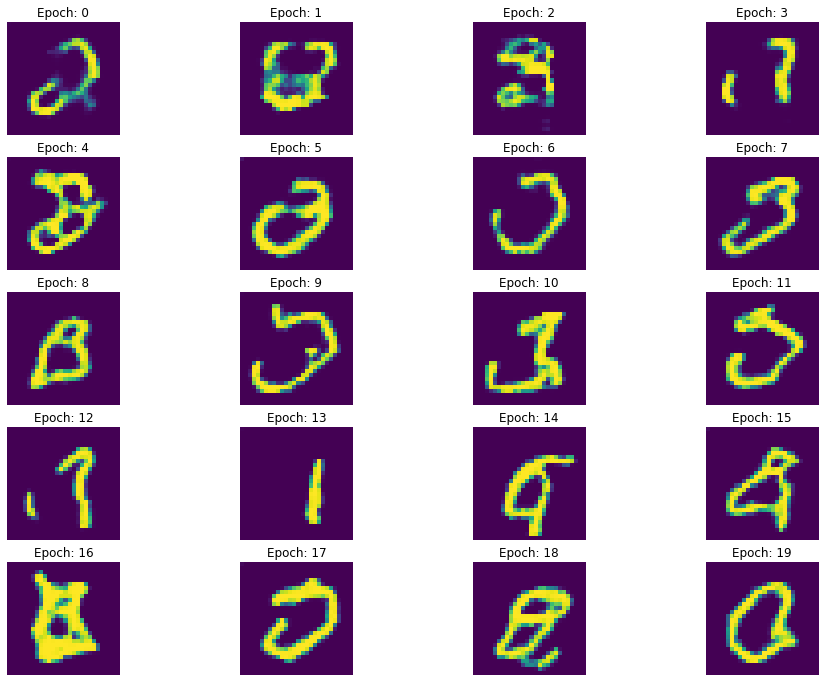

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))

for i, img in enumerate(my_images):
    ax = plt.subplot(5, 4, i+1)
    plt.imshow(img)
    plt.title('Epoch: {}'.format(i))
    plt.axis(False)